# AutoMPC Demo

Welcome!  This notebook demonstrates the core features of AutoMPC.  We will use the Cart-Pole swing-up task as an example, and we will tune an MPC pipeline consisting of a multi-layer perception (MLP) system ID model and an iLQR optimizer.

## Set-Up

To begin, we need an input dataset and specifications for the system and task.  The `benchmarks` module provides these for a few example systems.

In [1]:
import autompc as ampc
import numpy as np
from autompc.benchmarks import CartpoleSwingupV2Benchmark

benchmark = CartpoleSwingupV2Benchmark()


# Get system and task specification
system = benchmark.system
task   = benchmark.task

# Generate benchmark dataset
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

Cannot import SnoptWrapper
Cannot import KnitroSolver, make sure its Python interface is installed
running build_ext


The benchmark also provides capabilities to visualize trajectories.  We can use this to visualize one of the trajectories in our training set.

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


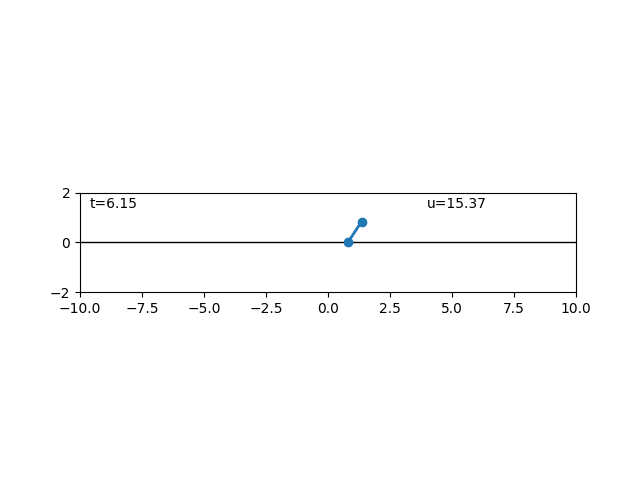

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpwfkc_mkp/temp.m4v']


In [37]:
from IPython.display import HTML

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, trajs[1])
HTML(anim.to_html5_video())

Next, we need to declare our MPC pipeline.  The following code initializes a pipeline with a MLP system ID model, a quadratic objective function, and and an iLQR optimizer.

In [3]:
from autompc.sysid import MLPFactory
from autompc.control import IterativeLQRFactory
from autompc.costs import QuadCostFactory

model_factory = MLPFactory(system)
ctrlr_factory = IterativeLQRFactory(system)
cost_factory  = QuadCostFactory(system)

pipeline = ampc.Pipeline(system, model_factory, ctrlr_factory, cost_factory)

We can view the joint configuration space of the pipeline

In [4]:
pipeline.get_configuration_space()

Configuration space object:
  Hyperparameters:
    _cost:dx_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:dx_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:omega_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:omega_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:theta_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:theta_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:u_R, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:x_F, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _cost:x_Q, Type: UniformFloat, Range: [0.001, 10000.0], Default: 1.0, on log-scale
    _ctrlr:horizon, Type: UniformInteger, Range: [5, 25], Default: 20
    _model:hidden_size_1, Type: UniformInteger, Range: [16, 256], Default: 128
   

## Tuning

Once we have initialized the pipeline and its factories, it is straightforward to set up a tuner to search the configuration space.  Here we use an MLP model for the surrogate model.  This is an example of full pipeline which searches the configuration space of all pipeline components simultaneously.

In [16]:
from autompc.tuning import PipelineTuner

tuner = PipelineTuner(surrogate_factory=MLPFactory(system), surrogate_split=0.5)

controller, tune_result = tuner.run(pipeline, task, trajs, n_iters=100, rng=np.random.default_rng(100), 
                                   truedyn=benchmark.dynamics)

/home/william/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


use_cuda=True
MLP Using Cuda
hidden_sizes= [128, 128]
100%|██████████| 50/50 [01:21<00:00,  1.63s/it]

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-05-28_21:31:37_794837
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 25 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design
INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent



use_cuda=True
MLP Using Cuda
hidden_sizes= [136, 136, 136]
100%|██████████| 50/50 [01:45<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:15<00:00, 12.70it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.90241050e+00 1.11841122e-02 1.47599915e+00 2.52527005e-03]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:15<00:00, 12.81it/s]

INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 200.0000



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.1510028  -0.03157506  1.85327658 -0.0565159 ]
use_cuda=True
MLP Using Cuda
hidden_sizes= [76, 76]
100%|██████████| 50/50 [01:23<00:00,  1.67s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:05<00:00, 38.66it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:05<00:00, 39.16it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 230.755489 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130246e+00 3.21985108e-04 8.80121485e-13 1.79778016e-13]
use_cuda=True
MLP Using Cuda
hidden_sizes= [196, 196, 76, 76]
100%|██████████| 50/50 [02:08<00:00,  2.58s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [02:03<00:01,  1.61it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.79424027  0.19413672  0.79088051 -0.20553387]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [02:13<00:01,  1.48it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 385.672400 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.13107044 -0.34301213  0.96883614  0.34194554]
use_cuda=True
MLP Using Cuda
hidden_sizes= [106]
100%|██████████| 50/50 [00:56<00:00,  1.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:38<00:00,  5.16it/s]
Surrogate Cost:  193.0
Surrogate Final State:  [ -1.05075104   0.66395594 -31.78685838 -10.37414662]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:26<00:00,  2.28it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (193.0000) is better than incumbent (200.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_F : 3.1622776601683813 -> 0.4216965034285823
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_Q : 3.1622776601683813 -> 0.4216965034285823
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_F : 3.1622776601683813 -> 23.713737056616576
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_Q : 3.1622776601683813 -> 0.007498942093324564
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_F : 3.1622776601683813 -> 1333.5214321633246
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_Q : 3.1622776601683813 -> 1333.5214321633246
INFO:smac.intensification.intensification.Intensifier:  _cost:u_R : 3.1622776601683813 -> 0.007498942093324564
INFO:smac.intens


True Dynamics Cost:  177.0
True Dynamics Final State:  [  0.38066777   0.43442767 -16.69435034  -4.50447305]
use_cuda=True
MLP Using Cuda
hidden_sizes= [226, 46, 166]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:10<00:00, 19.37it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.93693839 0.00634876 0.10703215 0.02491091]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:08<00:00, 23.34it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 125.271673 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14141842e+00 4.45548924e-04 3.05070499e-01 2.88299699e-02]
use_cuda=True
MLP Using Cuda
hidden_sizes= [46, 226]
100%|██████████| 50/50 [01:24<00:00,  1.69s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:07<00:00, 26.66it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.93492035  0.00340659 -0.0994553   0.0126685 ]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:07<00:00, 26.81it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 99.305012 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.14128168e+00  2.58765988e-04  3.30819364e-03 -6.98788300e-05]
use_cuda=True
MLP Using Cuda
hidden_sizes= [166, 106, 106, 226]
100%|██████████| 50/50 [02:04<00:00,  2.49s/it]
Simulating Surrogate Trajectory: 
  2%|▏         | 4/200 [00:00<00:06, 32.01it/s]

/home/william/proj/autompc_dev/autompc/control/ilqr.py:535: RuntimeWarning: invalid value encountered in double_scalars
  if (obj - new_obj) / (-expect_cost_reduction) > ls_cost_threshold:


 99%|█████████▉| 198/200 [00:06<00:00, 30.01it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 29.24it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 137.710814 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130246e+00 3.21985108e-04 0.00000000e+00 0.00000000e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [181, 61, 181]
100%|██████████| 50/50 [01:45<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:05<00:00, 33.40it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:05<00:00, 35.10it/s]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 117.441186 sec, available: 0.000010 sec)


True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.14130246e+00  3.21985108e-04 -3.06517212e-12 -6.18119480e-13]
use_cuda=True
MLP Using Cuda
hidden_sizes= [61]
100%|██████████| 50/50 [00:58<00:00,  1.17s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:18<00:00, 10.57it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.9374123   0.00747831 -0.0855552   0.00910982]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:16<00:00, 12.04it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 93.744223 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.14157572e+00 -4.44735391e-04  5.64026103e-02  3.88808621e-03]
use_cuda=True
MLP Using Cuda
hidden_sizes= [241, 121, 121, 241]
100%|██████████| 50/50 [02:11<00:00,  2.63s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:10<00:00, 18.43it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.94381123  0.00649071 -1.49041933 -0.07497619]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:09<00:00, 21.31it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 151.783317 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.13106837e+00  1.12070247e-03 -6.75898973e-01 -5.60852200e-02]
use_cuda=True
MLP Using Cuda
hidden_sizes= [121, 241]
100%|██████████| 50/50 [01:25<00:00,  1.71s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:27<00:00,  7.12it/s]
Surrogate Cost:  199.0
Surrogate Final State:  [ 1.41735397 -0.51057678  1.13656857 -6.2224776 ]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:32<00:00,  6.15it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 145.430821 sec, available: 0.000010 sec)



True Dynamics Cost:  197.0
True Dynamics Final State:  [-0.12035551 -0.00374261  0.13682603  0.44094136]
use_cuda=True
MLP Using Cuda
hidden_sizes= [211, 151, 151]
100%|██████████| 50/50 [01:48<00:00,  2.18s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:12<00:00,  2.72it/s]
Surrogate Cost:  109.0
Surrogate Final State:  [-1.51349139e-03  1.16916356e-01  1.37268993e+01  4.85250630e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:10<00:00,  2.82it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (109.0000) is better than incumbent (193.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_F : 0.4216965034285823 -> 0.1539926526059493
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_Q : 0.4216965034285823 -> 0.020535250264571463
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_F : 23.713737056616576 -> 3651.7412725483823
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_Q : 0.007498942093324564 -> 8.659643233600653
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_F : 1333.5214321633246 -> 1.1547819846894585
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_Q : 1333.5214321633246 -> 486.9675251658636
INFO:smac.intensification.intensification.Intensifier:  _cost:u_R : 0.007498942093324564 -> 0.020535250264571463
INFO:smac.inte


True Dynamics Cost:  182.0
True Dynamics Final State:  [-1.60394106e-02  1.21327792e-01  5.58707699e+01  5.95207186e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [91]
100%|██████████| 50/50 [00:57<00:00,  1.15s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:45<00:01,  1.89it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [  3.18900002  -0.23477102 -27.14650126  -4.41555804]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:46<00:01,  1.87it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 268.827116 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [  3.04224853   0.47324908 -24.33394404  -3.85287477]
use_cuda=True
MLP Using Cuda
hidden_sizes= [151, 211, 91, 91]
100%|██████████| 50/50 [02:02<00:00,  2.44s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:10<00:00, 18.34it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.95381821e+00  1.12968443e-03 -2.92786885e+00 -4.04411223e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 30.55it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 139.482598 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130183e+00 3.22053364e-04 1.03128839e-05 3.32544994e-06]
use_cuda=True
MLP Using Cuda
hidden_sizes= [31, 91]
100%|██████████| 50/50 [01:24<00:00,  1.69s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:07<00:00, 26.40it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.93778803  0.00631488 -0.08348978  0.00983592]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:07<00:00, 26.77it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 99.667406 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14145564e+00 3.05309200e-04 1.98420514e-02 1.02394025e-03]
use_cuda=True
MLP Using Cuda
hidden_sizes= [113, 204, 144, 38]
100%|██████████| 50/50 [02:03<00:00,  2.48s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:06<00:00, 29.65it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 30.49it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 137.018157 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130246e+00 3.21985108e-04 0.00000000e+00 0.00000000e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [234, 83]
100%|██████████| 50/50 [01:25<00:00,  1.71s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:23<00:00,  8.26it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.92031034 0.00424372 2.42339807 0.26538966]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:15<00:00,  2.61it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 185.296287 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.1471455  -0.00658029  2.81077016  0.27293018]
use_cuda=True
MLP Using Cuda
hidden_sizes= [53, 144, 83]
100%|██████████| 50/50 [01:48<00:00,  2.16s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:04<00:00,  3.07it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.12956848 -1.43060347 -0.04135637  2.71698965]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:13<00:00,  2.70it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 245.883195 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.14006424 -2.04814907 -0.1537131   2.52610366]
use_cuda=True
MLP Using Cuda
hidden_sizes= [174]
100%|██████████| 50/50 [00:59<00:00,  1.19s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:06<00:00, 30.59it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.94119106  0.00572242 -0.60040878 -0.04879139]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 30.92it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 72.333451 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.13875476e+00 7.98824483e-04 9.63774941e-01 1.33136031e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [23, 113, 174, 189]
100%|██████████| 50/50 [02:10<00:00,  2.61s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:12<00:00, 16.36it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.93754144 0.00385141 0.18178728 0.01407936]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:11<00:00, 16.53it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 154.819761 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14071703e+00 3.22478405e-03 2.16253777e-01 1.44429539e-04]
use_cuda=True
MLP Using Cuda
hidden_sizes= [144, 234]
100%|██████████| 50/50 [01:26<00:00,  1.73s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:37<00:00,  5.22it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 1.21077884  0.49896913 46.0152044   8.78054215]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:42<00:00,  4.63it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 167.352118 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 1.88934554 -0.72714787 30.07990069  7.88994158]
use_cuda=True
MLP Using Cuda
hidden_sizes= [83, 53, 113]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [02:06<00:01,  1.57it/s]
Surrogate Cost:  158.0
Surrogate Final State:  [-0.25245514 -0.0509859  26.1126964   2.22275541]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [02:07<00:01,  1.55it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 360.305900 sec, available: 0.000010 sec)



True Dynamics Cost:  186.0
True Dynamics Final State:  [-0.51495808 -0.0699645  44.27648124  5.59396217]
use_cuda=True
MLP Using Cuda
hidden_sizes= [204]
100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:12<00:00, 15.98it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.08867297 -0.04154148 18.07057013  1.40380655]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:11<00:00, 16.70it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 84.280734 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.40804963  0.18425485 18.96415186  1.41319198]
use_cuda=True
MLP Using Cuda
hidden_sizes= [219, 249]
100%|██████████| 50/50 [01:23<00:00,  1.68s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:09<00:00, 20.43it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.9384675   0.00678049 -0.11150068  0.01386809]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:09<00:00, 20.33it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 103.374249 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.14132182e+00 -4.62946388e-04 -1.08415063e-01  1.44197726e-06]
use_cuda=True
MLP Using Cuda
hidden_sizes= [98, 128, 189, 174]
100%|██████████| 50/50 [02:11<00:00,  2.62s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:45<00:00,  4.36it/s]
Surrogate Cost:  184.0
Surrogate Final State:  [ 0.15372861 -0.34047069 -5.93504316 -3.34510242]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:52<00:00,  3.80it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 228.686872 sec, available: 0.000010 sec)



True Dynamics Cost:  176.0
True Dynamics Final State:  [-0.21619452 -0.863729    5.34553171 -0.30739584]
use_cuda=True
MLP Using Cuda
hidden_sizes= [155]
100%|██████████| 50/50 [00:58<00:00,  1.16s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:06<00:00, 28.50it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.93812538  0.00464945 -0.13169121  0.01367811]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 29.75it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 71.800627 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.14180564e+00 -1.26729169e-04 -3.30327510e-02 -1.91349795e-04]
use_cuda=True
MLP Using Cuda
hidden_sizes= [88, 39, 214, 147]
100%|██████████| 50/50 [02:04<00:00,  2.49s/it]
Simulating Surrogate Trajectory: 
  3%|▎         | 6/200 [00:00<00:07, 27.56it/s]

/home/william/proj/autompc_dev/autompc/control/ilqr.py:535: RuntimeWarning: invalid value encountered in double_scalars
  if (obj - new_obj) / (-expect_cost_reduction) > ls_cost_threshold:


 99%|█████████▉| 198/200 [00:06<00:00, 29.34it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 29.15it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 138.076576 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130246e+00 3.21985108e-04 0.00000000e+00 0.00000000e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [73, 128, 128, 128]
100%|██████████| 50/50 [02:04<00:00,  2.50s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:49<00:01,  1.80it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 4.86007733e+00  1.92323333e-01 -2.68815303e+02 -5.44249686e+01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:42<00:01,  1.94it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 336.873789 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [   4.36174166   -0.25392267 -201.98147529  -35.81621462]
use_cuda=True
MLP Using Cuda
hidden_sizes= [78, 22, 197]
100%|██████████| 50/50 [01:44<00:00,  2.09s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:57<00:01,  1.68it/s]
Surrogate Cost:  122.0
Surrogate Final State:  [-0.05156265  0.04029755 -1.41467161 -0.33554604]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:15<00:00,  2.62it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 297.819052 sec, available: 0.000010 sec)



True Dynamics Cost:  51.0
True Dynamics Final State:  [-0.07530775 -0.00713917  3.0660188   0.30405773]
use_cuda=True
MLP Using Cuda
hidden_sizes= [162, 28, 243, 138]
100%|██████████| 50/50 [02:04<00:00,  2.50s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:14<00:00, 13.72it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [-1.16176083 -0.65431177 82.09223159  7.70979929]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:15<00:00, 12.51it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 155.252024 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ -2.09492152  -0.59867531  -9.56748956 -25.39363445]
use_cuda=True
MLP Using Cuda
hidden_sizes= [137, 27, 22]
100%|██████████| 50/50 [01:43<00:00,  2.07s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:23<00:00,  8.42it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.95273152 -0.00309477  0.10982544 -0.02034881]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:25<00:00,  7.88it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 152.018661 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.21837183e+00 -3.08187115e-03  1.21350929e+00 -3.52851513e-02]
use_cuda=True
MLP Using Cuda
hidden_sizes= [218, 117, 151]
100%|██████████| 50/50 [01:47<00:00,  2.16s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:56<00:00,  3.50it/s]
Surrogate Cost:  189.0
Surrogate Final State:  [ 9.05754144e-02 -1.79198466e-02  6.60723275e+01  5.23372811e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:57<00:00,  3.47it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 221.680975 sec, available: 0.000010 sec)



True Dynamics Cost:  191.0
True Dynamics Final State:  [-0.09467414  0.41245128 80.30428985  8.79269008]
use_cuda=True
MLP Using Cuda
hidden_sizes= [211, 151, 173]
100%|██████████| 50/50 [01:47<00:00,  2.14s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:54<00:00,  3.64it/s]
Surrogate Cost:  190.0
Surrogate Final State:  [ 1.08476193e-02  3.33486373e-01 -4.10394393e+01 -2.77498685e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:23<00:00,  8.38it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 185.120882 sec, available: 0.000010 sec)



True Dynamics Cost:  194.0
True Dynamics Final State:  [ 0.08833612 -2.15662163 34.40161945  0.86552042]
use_cuda=True
MLP Using Cuda
hidden_sizes= [206, 121, 189]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:17<00:00,  2.56it/s]
Surrogate Cost:  198.0
Surrogate Final State:  [6.45798687e-03 7.32161426e-03 7.72155123e+01 5.91934559e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:29<00:00,  2.21it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 272.232480 sec, available: 0.000010 sec)



True Dynamics Cost:  195.0
True Dynamics Final State:  [-2.29752449e-02 -1.03836378e-02  8.18361066e+01  8.56133214e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 151, 151]
100%|██████████| 50/50 [01:43<00:00,  2.08s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:58<00:00,  3.40it/s]
Surrogate Cost:  184.0
Surrogate Final State:  [ 1.36811683e-02 -2.77846455e-02  5.14935455e+01  3.66758532e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:55<00:00,  3.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 217.325447 sec, available: 0.000010 sec)



True Dynamics Cost:  187.0
True Dynamics Final State:  [ 6.30516686e-03 -2.81775610e-01  6.27762540e+01  6.24376246e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [84, 26, 197]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
  2%|▏         | 4/200 [00:00<00:05, 32.96it/s]

/home/william/proj/autompc_dev/autompc/control/ilqr.py:535: RuntimeWarning: invalid value encountered in double_scalars
  if (obj - new_obj) / (-expect_cost_reduction) > ls_cost_threshold:


 99%|█████████▉| 198/200 [00:05<00:00, 33.54it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:05<00:00, 33.77it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 117.116047 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130246e+00 3.21985108e-04 0.00000000e+00 0.00000000e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [211, 116, 170]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:58<00:00,  3.40it/s]
Surrogate Cost:  186.0
Surrogate Final State:  [ 3.70763334e-04 -8.46767658e-02  4.72090461e+01  3.29789104e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:50<00:00,  3.92it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 215.405609 sec, available: 0.000010 sec)



True Dynamics Cost:  185.0
True Dynamics Final State:  [ 0.13327525  0.87693171 61.26984099  7.04662041]
use_cuda=True
MLP Using Cuda
hidden_sizes= [231, 160]
100%|██████████| 50/50 [01:23<00:00,  1.68s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:38<00:00,  5.13it/s]
Surrogate Cost:  193.0
Surrogate Final State:  [ 5.17052953e-02 -4.06435651e-01  6.05226742e+01  5.59623772e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:39<00:00,  4.97it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 162.396352 sec, available: 0.000010 sec)



True Dynamics Cost:  193.0
True Dynamics Final State:  [ 5.77224503e-02 -9.08147665e-02  7.66186746e+01  7.98946759e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [174, 156, 151]
100%|██████████| 50/50 [01:46<00:00,  2.14s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:48<00:00,  4.07it/s]
Surrogate Cost:  189.0
Surrogate Final State:  [ 0.16668106 -0.5497942  52.91909752  3.32855425]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:50<00:00,  3.90it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 206.146635 sec, available: 0.000010 sec)



True Dynamics Cost:  195.0
True Dynamics Final State:  [-3.69235365e-02  6.07989851e-01  7.00823546e+01  7.77583149e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [211, 151, 137]
100%|██████████| 50/50 [01:44<00:00,  2.08s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:17<00:00,  2.55it/s]
Surrogate Cost:  189.0
Surrogate Final State:  [-6.02123190e-03  9.22989855e-02  7.89778823e+01  6.71408515e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:14<00:00,  2.67it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 255.805195 sec, available: 0.000010 sec)



True Dynamics Cost:  190.0
True Dynamics Final State:  [-3.83688862e-02  3.52687276e-01  7.98048788e+01  8.67966814e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [202, 135, 198]
100%|██████████| 50/50 [01:45<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:56<00:00,  3.50it/s]
Surrogate Cost:  177.0
Surrogate Final State:  [ 1.84843687e-02 -2.36285240e-02  3.69294520e+01  2.35190177e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:02<00:00,  3.15it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 225.484914 sec, available: 0.000010 sec)



True Dynamics Cost:  193.0
True Dynamics Final State:  [-7.59486610e-04 -1.92629545e-01  7.85757731e+01  7.87951709e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [186, 162, 188]
100%|██████████| 50/50 [01:46<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [02:03<00:01,  1.60it/s]
Surrogate Cost:  138.0
Surrogate Final State:  [-0.0049343  -0.39335177 -4.21206742 -1.70201095]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:57<00:01,  1.69it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 347.430109 sec, available: 0.000010 sec)



True Dynamics Cost:  194.0
True Dynamics Final State:  [ 0.15166619  0.58427456 23.41000176  2.70677305]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 168, 157]
100%|██████████| 50/50 [01:46<00:00,  2.14s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:23<00:00,  8.27it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [ 7.63314977e-05 -7.35854907e-03  2.89415125e+00 -6.30092012e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:58<00:00,  3.39it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (33.0000) is better than incumbent (109.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_Q : 0.020535250264571463 -> 0.009979973446074254
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_Q : 8.659643233600653 -> 26.550737911637853
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_F : 1.1547819846894585 -> 1.2952975406908955
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_Q : 486.9675251658636 -> 250.96665364379513
INFO:smac.intensification.intensification.Intensifier:  _cost:u_R : 0.020535250264571463 -> 0.019468829495094406
INFO:smac.intensification.intensification.Intensifier:  _cost:x_Q : 0.0027384196342643626 -> 0.0058092452168798684
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:horizon : 24 -> 25
INFO:smac.intensification.intensification


True Dynamics Cost:  136.0
True Dynamics Final State:  [-2.73450656e-03 -4.13660402e-03  2.07251097e+01  2.04350205e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 168]
100%|██████████| 50/50 [01:24<00:00,  1.69s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:30<00:00,  6.55it/s]
Surrogate Cost:  199.0
Surrogate Final State:  [-4.61721059e-03 -8.39581015e-03  9.62048099e+01  7.70457220e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:33<00:00,  5.94it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 148.133608 sec, available: 0.000010 sec)



True Dynamics Cost:  198.0
True Dynamics Final State:  [-2.53996563e-02  2.35165958e-02  1.10926542e+02  1.17031837e+01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 175, 164]
100%|██████████| 50/50 [01:39<00:00,  2.00s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:24<00:00,  8.02it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [-0.01976123 -0.01318845  0.07417847 -0.79871107]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:30<00:00,  6.45it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 155.364236 sec, available: 0.000010 sec)



True Dynamics Cost:  35.0
True Dynamics Final State:  [-0.04615054  0.01051249  9.26307551  0.96063942]
use_cuda=True
MLP Using Cuda
hidden_sizes= [254, 55, 172, 199]
100%|██████████| 50/50 [02:08<00:00,  2.58s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:12<00:00, 16.34it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.92087057 -0.00679654  2.91225236  0.12374595]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:11<00:00, 16.54it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 153.036752 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.19577628 -0.04731606  3.07910266  0.07745308]
use_cuda=True
MLP Using Cuda
hidden_sizes= [175, 122, 116]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:52<00:01,  1.77it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [-6.15701060e-02 -5.61282483e-02  7.45748473e+01  7.38634456e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:50<00:01,  1.79it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 329.272192 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [-5.06042240e-02 -4.77395219e-02  8.61536299e+01  9.90505094e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 175, 164]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:00<00:00,  3.28it/s]
Surrogate Cost:  154.0
Surrogate Final State:  [  0.19041906   0.03905981 -26.9737193   -3.50181638]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:55<00:00,  3.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 221.575362 sec, available: 0.000010 sec)



True Dynamics Cost:  121.0
True Dynamics Final State:  [ 1.50788827e-01  4.53901435e-03 -1.83981176e+01 -2.71956835e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 178, 156]
100%|██████████| 50/50 [01:46<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:57<00:00,  3.45it/s]
Surrogate Cost:  182.0
Surrogate Final State:  [-1.61936287e-03  1.30107046e-02  4.40610382e+01  2.94142533e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:56<00:00,  3.49it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 220.279598 sec, available: 0.000010 sec)



True Dynamics Cost:  189.0
True Dynamics Final State:  [-3.31109873e-02 -4.88104435e-01  7.36349824e+01  7.29863547e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 150, 189, 128]
100%|██████████| 50/50 [02:07<00:00,  2.54s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:13<00:00,  2.71it/s]
Surrogate Cost:  181.0
Surrogate Final State:  [  0.15855479   0.03292805 -29.6734557   -4.13208052]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:10<00:00,  2.79it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 271.171729 sec, available: 0.000010 sec)



True Dynamics Cost:  158.0
True Dynamics Final State:  [  0.1016512   -0.29217109 -22.16818608  -3.39929013]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 168, 147]
100%|██████████| 50/50 [01:44<00:00,  2.10s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:31<00:00,  6.25it/s]
Surrogate Cost:  151.0
Surrogate Final State:  [-1.53379377e-02 -6.97333516e-03  1.81983439e+01  4.98635841e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:40<00:00,  4.86it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 177.399076 sec, available: 0.000010 sec)



True Dynamics Cost:  172.0
True Dynamics Final State:  [-3.82507958e-02 -3.32762008e-03  3.54299050e+01  3.72529990e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 168, 198]
100%|██████████| 50/50 [01:44<00:00,  2.09s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [02:08<00:01,  1.54it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.33131839e-01  1.20438768e-02 -2.89735380e+01 -5.78566208e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [02:08<00:01,  1.55it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 361.230572 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.40200012e-01  2.45191860e-03 -2.28744207e+01 -4.91144550e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 168, 162]
100%|██████████| 50/50 [01:43<00:00,  2.06s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:58<00:00,  3.39it/s]
Surrogate Cost:  179.0
Surrogate Final State:  [1.95981085e-04 1.72991092e-02 3.31845379e+01 1.94196837e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:55<00:00,  3.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 216.634293 sec, available: 0.000010 sec)



True Dynamics Cost:  184.0
True Dynamics Final State:  [-8.65942015e-03 -1.01724080e-01  4.88012052e+01  4.99291671e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [251, 177, 166]
100%|██████████| 50/50 [01:48<00:00,  2.16s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:44<00:00,  4.41it/s]
Surrogate Cost:  185.0
Surrogate Final State:  [-0.06904265 -0.06898947 53.98247376  3.94183977]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:44<00:00,  4.46it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 197.599395 sec, available: 0.000010 sec)



True Dynamics Cost:  182.0
True Dynamics Final State:  [-0.14402665 -0.3366815  64.96633134  6.55478942]
use_cuda=True
MLP Using Cuda
hidden_sizes= [96, 63, 129, 195]
100%|██████████| 50/50 [02:04<00:00,  2.48s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:46<00:00,  4.29it/s]
Surrogate Cost:  167.0
Surrogate Final State:  [-0.09170662  0.00044462 -0.16248851  0.02881921]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:51<00:00,  3.84it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 221.872363 sec, available: 0.000010 sec)



True Dynamics Cost:  193.0
True Dynamics Final State:  [-0.31490532 -0.30275985 -0.1423517   0.00301845]
use_cuda=True
MLP Using Cuda
hidden_sizes= [254, 159, 168]
100%|██████████| 50/50 [01:47<00:00,  2.16s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:47<00:00,  4.15it/s]
Surrogate Cost:  188.0
Surrogate Final State:  [-1.07267780e-02  1.60188944e-01  6.19805680e+01  4.91907184e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:03<00:00,  3.10it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 219.620172 sec, available: 0.000010 sec)



True Dynamics Cost:  191.0
True Dynamics Final State:  [-2.71225815e-02 -1.43649995e-01  8.22531693e+01  8.53660195e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 174, 118]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:20<00:00,  9.90it/s]
Surrogate Cost:  48.0
Surrogate Final State:  [-0.03055384 -0.00676853  4.47534473 -0.51700768]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:24<00:00,  8.20it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 150.711964 sec, available: 0.000010 sec)



True Dynamics Cost:  106.0
True Dynamics Final State:  [-6.17946918e-02 -3.55333057e-03  1.40285450e+01  1.43996031e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 147, 157]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:17<00:00,  2.56it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 4.17378000e-01  7.82339328e-03 -8.48071689e+01 -1.10939808e+01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:18<00:00,  2.53it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 261.185288 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 5.09944486e-01  5.94455919e-02 -7.58570267e+01 -1.12309954e+01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [31, 112, 59, 56]
100%|██████████| 50/50 [02:06<00:00,  2.54s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:06<00:00, 30.47it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:06<00:00, 30.70it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 139.936012 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.14130246e+000  3.21985108e-004 -1.38862054e-122 -2.94317335e-123]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 171, 155, 140]
100%|██████████| 50/50 [02:05<00:00,  2.51s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:59<00:00,  3.35it/s]
Surrogate Cost:  165.0
Surrogate Final State:  [-0.02554279  0.04014051 24.35176256  1.24117462]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:55<00:00,  3.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 240.269112 sec, available: 0.000010 sec)



True Dynamics Cost:  185.0
True Dynamics Final State:  [9.36448393e-04 5.35387776e-01 5.39565810e+01 6.33721371e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 162, 156]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:17<00:00, 11.02it/s]
Surrogate Cost:  148.0
Surrogate Final State:  [ 1.84252827e-01  1.69321770e-02 -2.44502870e+01 -3.39189924e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:16<00:00, 11.77it/s]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 140.353565 sec, available: 0.000010 sec)


True Dynamics Cost:  109.0
True Dynamics Final State:  [  0.10598222   0.01854301 -15.37168797  -2.29863425]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 168, 156]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:30<00:00,  6.47it/s]
Surrogate Cost:  192.0
Surrogate Final State:  [ 5.56190235e-02 -7.30321204e-01  6.88901636e+01  5.29007328e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:25<00:00,  7.74it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 161.927793 sec, available: 0.000010 sec)



True Dynamics Cost:  189.0
True Dynamics Final State:  [-3.85386229e-02  6.68631611e-02  7.78056154e+01  8.25117933e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [206, 246, 146, 177]
100%|██████████| 50/50 [02:07<00:00,  2.56s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:14<00:00,  2.67it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 1.64255922  0.53647395  0.57487947 -0.82584136]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:13<00:00,  2.70it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 275.576709 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 1.18368684 -0.88370231  0.50940786 -0.75906745]
use_cuda=True
MLP Using Cuda
hidden_sizes= [245, 168, 160]
100%|██████████| 50/50 [01:40<00:00,  2.00s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:00<00:00,  3.26it/s]
Surrogate Cost:  187.0
Surrogate Final State:  [1.95861635e-02 4.50990412e-02 4.39701349e+01 2.97238910e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:03<00:00,  3.11it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 224.604752 sec, available: 0.000010 sec)



True Dynamics Cost:  193.0
True Dynamics Final State:  [8.21144322e-03 1.19176929e-01 6.25008783e+01 6.51210368e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 191, 158]
100%|██████████| 50/50 [01:47<00:00,  2.15s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:47<00:00,  4.13it/s]
Surrogate Cost:  141.0
Surrogate Final State:  [ 0.03029859  0.03145894 17.35492112  0.37754052]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:17<00:00,  2.54it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 233.511813 sec, available: 0.000010 sec)



True Dynamics Cost:  173.0
True Dynamics Final State:  [-0.08262476  0.693626   39.02779087  4.68297362]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 171]
100%|██████████| 50/50 [01:25<00:00,  1.70s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:50<00:00,  3.90it/s]
Surrogate Cost:  195.0
Surrogate Final State:  [-8.21732902e-02  3.54936289e-02  5.54245706e+01  4.60323887e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:40<00:00,  4.93it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 176.164484 sec, available: 0.000010 sec)



True Dynamics Cost:  198.0
True Dynamics Final State:  [-0.19531434  1.06648599 77.67800607  9.53520626]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 175, 166]
100%|██████████| 50/50 [01:46<00:00,  2.14s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:30<00:00,  2.20it/s]
Surrogate Cost:  190.0
Surrogate Final State:  [-5.84416633e-03  2.16867128e-01  6.22805040e+01  5.66418810e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:34<00:00,  2.10it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 291.141578 sec, available: 0.000010 sec)



True Dynamics Cost:  190.0
True Dynamics Final State:  [ 0.06794769 -0.61800097 67.26184224  6.18029555]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 160, 157]
100%|██████████| 50/50 [01:47<00:00,  2.15s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:02<00:00,  3.15it/s]
Surrogate Cost:  181.0
Surrogate Final State:  [ 1.33373063e-02 -6.14005759e-02  3.55507035e+01  2.08821503e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:49<00:00,  4.00it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 220.162931 sec, available: 0.000010 sec)



True Dynamics Cost:  192.0
True Dynamics Final State:  [4.22300202e-02 2.35866222e-01 6.92740581e+01 7.33892234e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 184, 159]
100%|██████████| 50/50 [01:47<00:00,  2.14s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:59<00:00,  3.31it/s]
Surrogate Cost:  150.0
Surrogate Final State:  [-7.48307235e-03  1.94082135e-02  2.04053139e+01  8.29847985e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:51<00:00,  3.86it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 218.328387 sec, available: 0.000010 sec)



True Dynamics Cost:  179.0
True Dynamics Final State:  [-2.69903870e-02  9.60922164e-02  4.81067283e+01  5.16360750e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [53, 68, 135]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
  3%|▎         | 6/200 [00:00<00:08, 23.52it/s]

/home/william/proj/autompc_dev/autompc/control/ilqr.py:535: RuntimeWarning: invalid value encountered in double_scalars
  if (obj - new_obj) / (-expect_cost_reduction) > ls_cost_threshold:


 99%|█████████▉| 198/200 [00:06<00:00, 29.86it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.00152862  0.00701982 -3.49739905 -0.63817321]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:05<00:00, 33.07it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 118.995565 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.14130246e+00 3.21985108e-04 0.00000000e+00 0.00000000e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [246, 195, 157]
100%|██████████| 50/50 [01:46<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:29<00:00,  6.64it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [ 1.50290022e-01  4.69781962e-03 -6.92210167e+00 -1.67165182e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:35<00:00,  5.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 171.375686 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [ 0.01618948 -0.00889567  1.05046183 -0.08845788]
use_cuda=True
MLP Using Cuda
hidden_sizes= [67, 172, 31, 154]
100%|██████████| 50/50 [02:07<00:00,  2.55s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:14<00:00, 13.99it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.48565261  0.01767705 10.04643606  2.07609344]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:13<00:00, 14.83it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 155.083514 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.87865805  0.0161469  11.70384355  2.30981609]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 164]
100%|██████████| 50/50 [01:45<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:36<00:00,  2.05it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-0.02341601 -0.05909601  7.2012672   0.04866064]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:37<00:00,  2.04it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (31.0000) is better than incumbent (33.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_F : 0.1539926526059493 -> 0.27511817420217327
INFO:smac.intensification.intensification.Intensifier:  _cost:dx_Q : 0.009979973446074254 -> 0.10084470626574535
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_F : 3651.7412725483823 -> 3150.2094846292816
INFO:smac.intensification.intensification.Intensifier:  _cost:omega_Q : 26.550737911637853 -> 2.718697343232345
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_F : 1.2952975406908955 -> 2.027470612070089
INFO:smac.intensification.intensification.Intensifier:  _cost:theta_Q : 250.96665364379513 -> 29.091796574621966
INFO:smac.intensification.intensification.Intensifier:  _cost:u_R : 0.019468829495094406 -> 0.020535250264571463
INFO:smac.intens


True Dynamics Cost:  30.0
True Dynamics Final State:  [-0.04916948 -0.18815302  9.10978411  0.75091789]
use_cuda=True
MLP Using Cuda
hidden_sizes= [197, 254, 199]
100%|██████████| 50/50 [01:43<00:00,  2.08s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:16<00:00, 11.70it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.21324491  0.0859587   0.69507522 -0.31796927]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:12<00:00, 15.86it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 133.447862 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.12133786 -0.0315349  -0.15923581 -0.023619  ]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 193, 164]
100%|██████████| 50/50 [01:42<00:00,  2.06s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:16<00:00, 12.09it/s]
Surrogate Cost:  34.0
Surrogate Final State:  [-2.09624314e-03 -7.77653476e-03  7.65986834e+00 -3.17045750e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:19<00:00, 10.40it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 138.252774 sec, available: 0.000010 sec)



True Dynamics Cost:  121.0
True Dynamics Final State:  [-1.30449924e-02 -1.29910128e-03  1.77087821e+01  1.77538820e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 186, 177, 119]
100%|██████████| 50/50 [02:06<00:00,  2.53s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:14<00:00, 13.25it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [ 2.25008468e-02 -1.96923797e-03 -2.38039276e+00 -1.00513610e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:18<00:00, 10.81it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 159.834802 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-4.63757830e-02 -5.57694483e-03  7.50861077e+00  7.54392935e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 183, 125]
100%|██████████| 50/50 [02:03<00:00,  2.47s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:55<00:01,  1.71it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [  0.97126738  -0.14175663 -20.76033435  -4.95532043]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [02:06<00:01,  1.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 365.269485 sec, available: 0.000010 sec)



True Dynamics Cost:  177.0
True Dynamics Final State:  [  0.695411     0.51590717 -11.53452293  -2.0204782 ]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 175, 164]
100%|██████████| 50/50 [01:45<00:00,  2.11s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:43<00:00,  4.57it/s]
Surrogate Cost:  156.0
Surrogate Final State:  [-1.33731539e-01 -1.41576132e-02  2.64578506e+01  1.82523881e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:53<00:00,  3.73it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 201.759708 sec, available: 0.000010 sec)



True Dynamics Cost:  164.0
True Dynamics Final State:  [-2.48310577e-01 -3.66331678e-02  4.01367257e+01  4.56971010e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 204, 157]
100%|██████████| 50/50 [01:44<00:00,  2.08s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:48<00:00,  4.10it/s]
Surrogate Cost:  41.0
Surrogate Final State:  [ 0.22629009 -0.0342806  -3.73461871 -1.11222022]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:32<00:00,  6.12it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 184.786696 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-0.14500989 -0.0368454   3.87207934  0.47540373]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 203, 164]
100%|██████████| 50/50 [01:47<00:00,  2.15s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:34<00:00,  5.77it/s]
Surrogate Cost:  42.0
Surrogate Final State:  [ 0.09665586 -0.0146959  -5.54040147 -1.57561612]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:40<00:00,  4.94it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 181.924155 sec, available: 0.000010 sec)



True Dynamics Cost:  39.0
True Dynamics Final State:  [ 4.53118902e-03 -3.23586512e-02  4.91092178e+00  2.86545470e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 193, 177]
100%|██████████| 50/50 [01:43<00:00,  2.08s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:17<00:00, 11.26it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-0.01364876 -0.00685458  0.21180369 -0.72576715]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:31<00:00,  6.39it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 152.469418 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-3.87833855e-02 -3.88471629e-03  7.36638603e+00  7.35979632e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 185, 163]
100%|██████████| 50/50 [01:43<00:00,  2.06s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:03<00:00,  3.14it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [  1.18251222   0.06044448 -26.64730314  -7.02654558]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:12<00:00,  2.71it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 239.325557 sec, available: 0.000010 sec)



True Dynamics Cost:  182.0
True Dynamics Final State:  [  1.03522832   0.11564988 -17.58322686  -4.36831185]
use_cuda=True
MLP Using Cuda
hidden_sizes= [135, 104, 31, 110]
100%|██████████| 50/50 [02:02<00:00,  2.45s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:30<00:00,  6.58it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.81699345 0.22393209 7.50702834 1.30652457]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:48<00:00,  4.06it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 201.454005 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.71824506 -0.2114799  -0.52901662 -1.59173806]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 222, 176]
100%|██████████| 50/50 [01:44<00:00,  2.10s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:50<00:01,  1.79it/s]
Surrogate Cost:  171.0
Surrogate Final State:  [-1.18794478e-03  1.15610533e-02  3.29184224e+01  1.90490719e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:46<00:01,  1.86it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 322.089348 sec, available: 0.000010 sec)



True Dynamics Cost:  173.0
True Dynamics Final State:  [-1.36570405e-02  1.84722973e-01  4.45758894e+01  4.80634326e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 175]
100%|██████████| 50/50 [01:47<00:00,  2.15s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:05<00:00,  3.01it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 1.20946607e+00  1.29508072e-02 -3.17821544e+01 -8.42993457e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:49<00:00,  3.97it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 223.060553 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [  1.10049126   0.34317084 -18.18597677  -4.02946664]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 193]
100%|██████████| 50/50 [01:24<00:00,  1.69s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:11<00:00, 17.11it/s]
Surrogate Cost:  39.0
Surrogate Final State:  [ 0.01739434 -0.00277813 -2.7756291  -1.06132943]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:12<00:00, 15.66it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 108.961939 sec, available: 0.000010 sec)



True Dynamics Cost:  38.0
True Dynamics Final State:  [-3.89201052e-02 -3.20097608e-03  5.52772745e+00  5.19712416e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [35, 193]
100%|██████████| 50/50 [01:23<00:00,  1.66s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:52<00:00,  3.81it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [-1.36173419 -0.73848762  2.58704237 -0.03341848]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:40<00:00,  4.83it/s]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 176.081717 sec, available: 0.000010 sec)


True Dynamics Cost:  196.0
True Dynamics Final State:  [-0.32729039 -0.40127862  1.51170923  1.4078106 ]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 202, 169]
100%|██████████| 50/50 [01:43<00:00,  2.07s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:16<00:00, 12.06it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-0.00881589 -0.00697554  0.73088635 -0.71886178]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:25<00:00,  7.82it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 145.505963 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-3.37162078e-02 -3.63250482e-03  9.29396411e+00  9.26612973e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 193, 173]
100%|██████████| 50/50 [01:41<00:00,  2.04s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:52<00:00,  3.81it/s]
Surrogate Cost:  103.0
Surrogate Final State:  [ 6.94292697e-02  6.54400491e-03 -1.69357270e+01 -2.31723935e+00]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:37<00:00,  5.24it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 191.713815 sec, available: 0.000010 sec)



True Dynamics Cost:  44.0
True Dynamics Final State:  [ 3.19911778e-02 -7.20605934e-03 -7.66807746e+00 -1.20082244e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 194, 202]
100%|██████████| 50/50 [01:44<00:00,  2.09s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:40<00:00,  4.90it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [ 0.00426082 -0.05645329 -0.83317533 -0.86868875]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:58<00:00,  3.39it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 203.552112 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-1.30168163e-02 -2.34319908e-03  6.29760693e+00  5.46932109e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 189]
100%|██████████| 50/50 [01:44<00:00,  2.10s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:20<00:00,  2.47it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [-0.04998944 -0.01025068 -0.19441761 -0.68082901]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [02:03<00:01,  1.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 308.636587 sec, available: 0.000010 sec)



True Dynamics Cost:  63.0
True Dynamics Final State:  [-0.12947785 -0.03134919  9.41405279  1.09484724]
use_cuda=True
MLP Using Cuda
hidden_sizes= [186]
100%|██████████| 50/50 [00:59<00:00,  1.20s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:43<00:01,  1.91it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.49856829  0.09702562 17.86486459  3.05498273]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:41<00:01,  1.96it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 264.344462 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.18310304  0.66030379 26.11689273  3.72968098]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 202, 152]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:30<00:00,  6.52it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [ 0.02322774 -0.00870261 -3.58971851 -1.21699452]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:30<00:00,  6.43it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 167.883812 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [ 1.72634655e-02 -6.94711134e-04  4.54501030e+00  2.64313007e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 195, 178, 109]
100%|██████████| 50/50 [02:08<00:00,  2.57s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:46<00:00,  4.29it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [ 0.03096383  0.11085552 -5.97582916 -1.01623909]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:17<00:00, 11.56it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 192.010637 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-2.48053967e-04  3.09825444e-04  8.62763809e-01 -3.86443956e-02]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 201]
100%|██████████| 50/50 [01:22<00:00,  1.64s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:47<00:00,  4.17it/s]
Surrogate Cost:  144.0
Surrogate Final State:  [ 5.91527667e-03 -1.18346085e-02  1.84587452e+01  2.88439163e-01]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:16<00:00,  2.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 206.648427 sec, available: 0.000010 sec)



True Dynamics Cost:  152.0
True Dynamics Final State:  [3.37840476e-02 1.13351171e-02 2.95429748e+01 2.87125026e+00]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 212, 153, 146]
100%|██████████| 50/50 [02:05<00:00,  2.52s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:19<00:00, 10.19it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [ 0.01222539 -0.00396814 -3.01639929 -1.03150372]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:22<00:00,  8.77it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 167.864510 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.86049804e-02 -2.56878683e-03  4.28402564e+00  3.48972202e-01]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 224, 175, 133]
100%|██████████| 50/50 [02:08<00:00,  2.57s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:36<00:00,  2.04it/s]
Surrogate Cost:  41.0
Surrogate Final State:  [ 0.13781409  0.12871715 -7.6504266  -1.44454256]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:54<00:01,  1.73it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 339.545085 sec, available: 0.000010 sec)



True Dynamics Cost:  35.0
True Dynamics Final State:  [ 0.03318043 -0.06512253  3.00027317 -0.02248712]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 172]
100%|██████████| 50/50 [01:46<00:00,  2.14s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:22<00:00,  8.88it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-0.01607478 -0.00300923  0.82537633 -0.61617673]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:49<00:00,  4.01it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 178.675380 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-0.06831356 -0.01649758  8.49771132  0.94258241]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 172]
100%|██████████| 50/50 [01:44<00:00,  2.10s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [01:15<00:00,  2.61it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [-0.04349822  0.03765196  6.71216036  0.02996453]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [01:10<00:00,  2.82it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 250.899909 sec, available: 0.000010 sec)



True Dynamics Cost:  93.0
True Dynamics Final State:  [-0.08707041 -0.02873931 14.80670686  1.63481976]
use_cuda=True
MLP Using Cuda
hidden_sizes= [256, 186, 128]
100%|██████████| 50/50 [01:46<00:00,  2.12s/it]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:12<00:00, 16.27it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [ 0.00221357  0.00626794 -0.22963343 -0.62680705]
Simulating True Dynamics Trajectory
 99%|█████████▉| 198/200 [00:56<00:00,  3.50it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 174.990894 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 4
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 100 / 100.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 100 / 100.0
INFO:smac.stats.stats.Stats:#Configurations: 100
INFO:smac.stats.stats.Stats:Used wallclock time: 20021.64 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 19888.66 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  _cost:dx_F, Value: 0.27511817420217327
  _cost:dx_Q, Value: 0.10084470626574535
  _cost:omega_F, Value: 3150.2094846292816
  _cost:omega_Q, Value: 2.718697343232345
 


True Dynamics Cost:  44.0
True Dynamics Final State:  [-0.18782539  0.03639713  9.50087709  1.35264106]
use_cuda=True
MLP Using Cuda
hidden_sizes= [255, 186, 164]
100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


It is then easy to plot the curve from the tuning result.

<IPython.core.display.Javascript object>


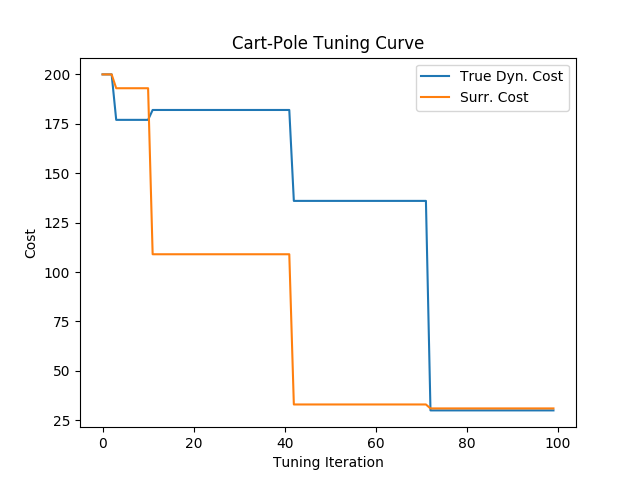

In [17]:
from autompc.graphs import TuningCurveGraph
import matplotlib.pyplot as plt

graph = TuningCurveGraph()

fig = plt.figure()      
ax = fig.gca()
graph(ax, tune_result)
ax.set_title("Cart-Pole Tuning Curve")
plt.show()

We can then use the resulting controller to simulate a trajectory and visualize a trajectory. For example,

In [32]:
traj = ampc.simulate(controller, init_obs=benchmark.task.get_init_obs(), max_steps=200, dynamics=benchmark.dynamics)

100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


<IPython.core.display.Javascript object>


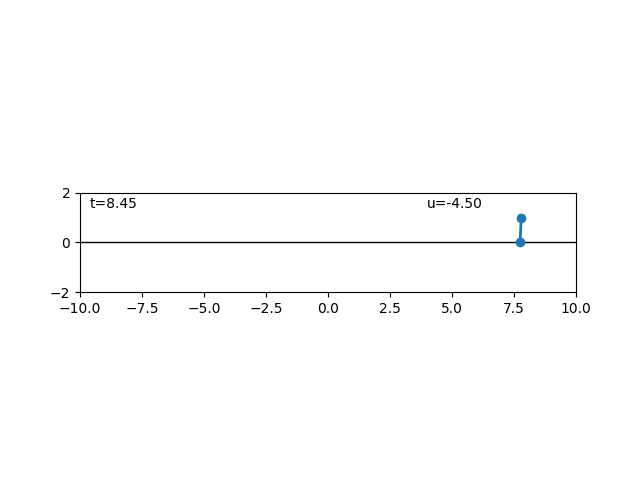

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpgdmjiu0o/temp.m4v']


In [36]:
from IPython.display import HTML

fig = plt.figure()
ax = fig.gca()
anim = benchmark.visualize(fig, ax, traj)
HTML(anim.to_html5_video())

## Decoupled Tuning

The above examples is full pipeline tuning, which searches the configuration space of all components simultaneously.  Alternatively, we can take a decoupled tuning approach, where the model is first tuned based on prediction accuracy, then the objective function and optimizer are tuned.

First, we must tune the model

In [ ]:
from autompc.tuning import ModelTuner
from autompc.evaluation import HoldoutModelEvaluator

model_evaluator = HoldoutModelEvaluator(holdout_prop=0.25, metric="rmse", trajs=trajs, system=system,
                                       rng=np.random.default_rng(100))
model_tuner = ModelTuner(system, model_evaluator)
model_tuner.add_model_factory(model_factory)

model, model_tune_result = model_tuner.run(rng=np.random.default_rng(100), n_iters=2)

Now that we have tuned the model, we can create a pipeline with the pre-tuned model, and then run pipeline tuning.

In [ ]:
pipeline_fixed_model = ampc.Pipeline(system, model, ctrlr_factory, cost_factory)
controller2, tune_result2 = tuner.run(pipeline_fixed_model, task, trajs, n_iters=100, rng=np.random.default_rng(100), 
                                   truedyn=benchmark.dynamics)